In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import glob
import os
import sys
%matplotlib inline

In [42]:
output_dir = "/home/nfs/rzamora/workspace/rapids-dl/ParallelPyTorchTabular/results/"
output_files = ["output.23-July-2019-20-09-37"]

In [43]:
results_template = {
    "batch-size": [],
    "epochs": [],
    "optimizer": [],
    "lr": [],
    "momentum": [],
    "wd": [],
    "batched-data": [],
    "method": [],
    "procs": [],
    "gpus": [],
    "loss-history": [],
    "loss": [],
    "time": [],
    "rate": [],
}

results = results_template.copy()

for file in glob.glob(output_dir+"*"):

    # Only parse specific files if output_files is populated
    if output_files and (os.path.basename(file) not in output_files):
        continue
    
    def _update_from_command(cmd_list):
        # Defaults
        mydict = {}
        mydict["batch-size"] = 80960
        mydict["epochs"] = 10
        mydict["optimizer"] = "SGD"
        mydict["lr"] = 0.01
        mydict["momentum"] = 0.9
        mydict["wd"] = 0.00005
        mydict["batched-data"] = False
        mydict["method"] = "serial"
        mydict["procs"] = 1
        mydict["gpus"] = 1
        mydict["loss-history"] = []
        # Parse Command to update defaults
        i = 0
        while i < len(cmd_list):
            val = cmd_list[i]
            if val == "--batch-size":
                mydict["batch-size"] = int(cmd_list[i+1]); i += 1
            elif val == "--epochs":
                mydict["epochs"] = int(cmd_list[i+1]); i += 1
            elif val == "--adam":
                mydict["optimizer"] = "Adam"
            elif val == "--lr":
                mydict["lr"] = float(cmd_list[i+1]); i += 1
            elif val == "--momentum":
                mydict["momentum"] = float(cmd_list[i+1]); i += 1
            elif val == "--wd":
                mydict["wd"] = float(cmd_list[i+1]); i += 1
            elif val == "--batched":
                mydict["batched-data"] = True
            elif val == "--par":
                mydict["method"] = cmd_list[i+1]; i += 1
            elif val == "--hogwild-procs":
                mydict["procs"] = int(cmd_list[i+1]); i += 1
            elif val == "--hogwild-gpus":
                mydict["gpus"] = int(cmd_list[i+1]); i += 1
            elif val == "-n":
                # Use mpirun procs here (horovod)
                mydict["procs"] = int(cmd_list[i+1])
                mydict["gpus"] = int(cmd_list[i+1]); i += 1
            i += 1

        if "--no-cuda" in cmd_list:
            mydict["gpus"] = 0
            
        return mydict
            

    #print(os.path.basename(file))
    with open(file, 'r') as f:
        line = f.readline()
        while line:
            sline = line.split()
            if sline:
                
                # Beginning a new experiment
                if len(sline) > 1 and sline[:2] == ["Experiment","Number"]:
                    result = {}
                    
                elif len(sline) > 1 and sline[:1] == ["command:"]:
                    result = _update_from_command(sline[1:])
                    
                elif len(sline) > 1 and sline[:1] == ["CUDA_VISIBLE_DEVICES:"]:
                    ngpus = len(sline[1].split(","))
                    if result["method"] == "bps":
                        result["gpus"] = ngpus
                    elif result["method"] in ["hvd", "hog"]:
                        result["gpus"] = min(result["gpus"], ngpus)
                    
                elif len(sline) > 1 and sline[:2] == ["Train","Epoch:"]:
                    loss = float(sline[sline.index("Loss:")+1])
                    result["loss-history"].append(loss)
                    result["loss"] = loss
                    
                elif len(sline) > 2 and sline[1:3] == ["Epochs","in"]:
                    result["time"] = float(sline[3])
                    
                elif len(sline) > 1 and sline[:2] == ["Training","Rate"]:
                    result["rate"] = float(sline[3])
                    # Append results for this experiment...
                    for key in results:
                        results[key].append(result[key])
            
            line = f.readline()
            
    df = pd.DataFrame(results)
df

,batch-size,epochs,optimizer,lr,momentum,wd,batched-data,method,procs,gpus,loss-history,loss,time,rate
0,100000,10,Adam,0.010,0.9,0.00005,True,serial,1,1,"[0.710218, 0.048567, 0.048565, 0.048241, 0.045...",0.026173,249.778352,3.483088e+05
1,1000,10,SGD,0.005,0.0,0.00000,True,serial,1,1,"[0.71014, 0.122616, 0.102516, 0.113002, 0.1348...",0.062772,1147.601315,7.525262e+04
2,10000,10,SGD,0.005,0.0,0.00000,True,serial,1,1,"[0.710154, 0.146554, 0.143871, 0.121631, 0.111...",0.109706,289.227051,2.987272e+05
3,100000,10,SGD,0.005,0.0,0.00000,True,serial,1,1,"[0.710218, 0.58174, 0.580469, 0.481708, 0.4794...",0.142233,230.013687,3.782384e+05
4,1000,10,SGD,0.008,0.0,0.00000,True,serial,1,1,"[0.71014, 0.104267, 0.101749, 0.11285, 0.13462...",0.056742,1147.418188,7.526463e+04
5,10000,10,SGD,0.008,0.0,0.00000,True,serial,1,1,"[0.710154, 0.119086, 0.115683, 0.121166, 0.110...",0.109110,291.006989,2.969001e+05
6,100000,10,SGD,0.008,0.0,0.00000,True,serial,1,1,"[0.710218, 0.519189, 0.517427, 0.386862, 0.383...",0.114246,234.691077,3.707001e+05
7,1000,10,SGD,0.010,0.0,0.00000,True,serial,1,1,"[0.71014, 0.102581, 0.101671, 0.112754, 0.1344...",0.054095,1146.627974,7.531649e+04
8,10000,10,SGD,0.010,0.0,0.00000,True,serial,1,1,"[0.710154, 0.116509, 0.112873, 0.121135, 0.110...",0.108617,290.189652,2.977363e+05
9,100000,10,SGD,0.010,0.0,0.00000,True,serial,1,1,"[0.710218, 0.481914, 0.479898, 0.335306, 0.331...",0.111418,230.333772,3.777127e+05


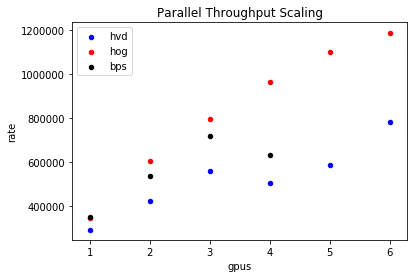

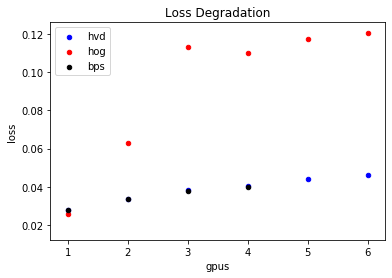

In [67]:
df_hvd = df[df["method"] == "hvd"]
df_hog = df[df["method"] == "hog"]
df_bps = df[df["method"] == "bps"]

ax1 = plt.gca()
ax1.set_title("Parallel Throughput Scaling")
df_hvd.plot(kind="scatter", x = "gpus", y = "rate", color = "blue", label = "hvd", ax=ax1)
df_hog.plot(kind="scatter", x = "gpus", y = "rate", color = "red", label = "hog", ax=ax1)
df_bps.plot(kind="scatter", x = "gpus", y = "rate", color = "black", label = "bps", ax=ax1)
plt.show()

ax2 = plt.gca()
ax2.set_title("Loss Degradation")
df_hvd.plot(kind="scatter", x = "gpus", y = "loss", color = "blue", label = "hvd", ax=ax2)
df_hog.plot(kind="scatter", x = "gpus", y = "loss", color = "red", label = "hog", ax=ax2)
df_bps.plot(kind="scatter", x = "gpus", y = "loss", color = "black", label = "bps", ax=ax2)
plt.show()

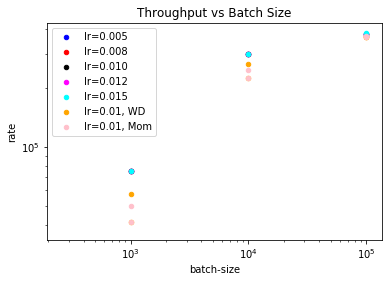

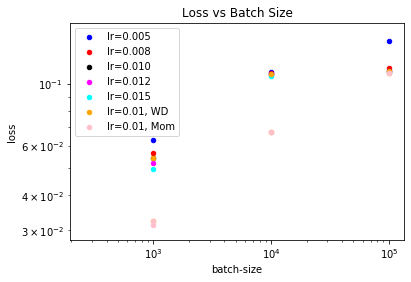

In [68]:
df_serial = df[df["method"] == "serial"]
df_serial = df_serial[df_serial["optimizer"] == "SGD"]
df_wd = df_serial[df_serial["wd"] != 0].copy()
df_mom = df_serial[df_serial["momentum"] != 0].copy()
df_serial = df_serial[df_serial["wd"] == 0]
df_serial = df_serial[df_serial["momentum"] == 0]
df_lrs = {
    "0.005" : df_serial[df_serial["lr"] == 0.005],
    "0.008" : df_serial[df_serial["lr"] == 0.008],
    "0.010" : df_serial[df_serial["lr"] == 0.010],
    "0.012" : df_serial[df_serial["lr"] == 0.012],
    "0.015" : df_serial[df_serial["lr"] == 0.015],
    "0.020" : df_serial[df_serial["lr"] == 0.020],
}

colors = ["blue", "red", "black", "magenta", "cyan", "green"]

ax3 = plt.gca()
ax3.set_title("Throughput vs Batch Size")
for i, key in enumerate(df_lrs):
    if len(df_lrs[key]["batch-size"]) > 0:
        df_lrs[key].plot(kind="scatter", x = "batch-size", y = "rate", color = colors[i], label = "lr="+key, ax=ax3)
df_wd.plot(kind="scatter", x = "batch-size", y = "rate", color = "orange", label = "lr=0.01, WD", ax=ax3)
df_mom.plot(kind="scatter", x = "batch-size", y = "rate", color = "pink", label = "lr=0.01, Mom", ax=ax3)
ax3.set_xscale('log')
ax3.set_yscale('log')
plt.show()

ax4 = plt.gca()
ax4.set_title("Loss vs Batch Size")
for i, key in enumerate(df_lrs):
    if len(df_lrs[key]["batch-size"]) > 0:
        df_lrs[key].plot(kind="scatter", x = "batch-size", y = "loss", color = colors[i], label = "lr="+key, ax=ax4)
df_wd.plot(kind="scatter", x = "batch-size", y = "loss", color = "orange", label = "lr=0.01, WD", ax=ax4)
df_mom.plot(kind="scatter", x = "batch-size", y = "loss", color = "pink", label = "lr=0.01, Mom", ax=ax4)
ax4.set_xscale('log')
ax4.set_yscale('log')
plt.show()

In [69]:
df_serial = df[df["method"] == "serial"]
df_serial = df_serial[df_serial["optimizer"] == "SGD"]
df_serial = df_serial[df_serial["batch-size"] == 10000]
df_serial = df_serial[df_serial["wd"] == 0]
df_serial = df_serial[df_serial["lr"] == 0.01]

df_serial
#record = df_serial[df_serial["optimizer"] == "SGD"]

,batch-size,epochs,optimizer,lr,momentum,wd,batched-data,method,procs,gpus,loss-history,loss,time,rate
8,10000,10,SGD,0.01,0.0,0.0,True,serial,1,1,"[0.710154, 0.116509, 0.112873, 0.121135, 0.110...",0.108617,290.189652,297736.322686
20,10000,10,SGD,0.01,0.9,0.0,True,serial,1,1,"[0.710154, 0.114591, 0.110848, 0.11649, 0.1058...",0.067271,350.244037,246685.141720


<function matplotlib.pyplot.show(*args, **kw)>

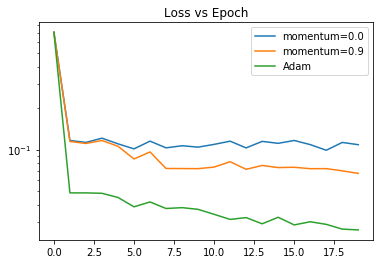

In [70]:
df_adam = df.copy()
df_adam = df_adam[df_adam["procs"] == 1]
df_adam = df_adam[df_adam["gpus"] == 1]
df_adam = df_adam[df_adam["method"] == "serial"]
df_adam = df_adam[df_adam["optimizer"] == "Adam"]
df_adam = df_adam[df_adam["batch-size"] == 100000]


ax5 = plt.gca()
ax5.set_title("Loss vs Epoch")

for index, row in df_serial.iterrows():
    ax5.plot(row['loss-history'], label='momentum='+str(row['momentum']))
    
for index, row in df_adam.iterrows():
    ax5.plot(row['loss-history'], label='Adam')
    
ax5.set_yscale('log')
ax5.legend(loc='best')
plt.show